In [362]:
import geopandas
from shapely.geometry import Point, LineString
from geopandas import GeoDataFrame
import spaghetti
from haversine import haversine
import pandas as pd
import numpy as np
import networkx as nx
import osmnx
import random
from matplotlib import pyplot as plt
import seaborn as sns
import esda
import warnings

warnings.filterwarnings("ignore")

Center Latitude: 53.809128400000006, Longitude: -1.5302367852524053.


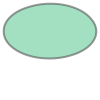

In [191]:
PLACE_OF_INTEREST = "Leeds City Centre, Leeds, United Kingdom"
leeds_center = osmnx.geocode_to_gdf(PLACE_OF_INTEREST, buffer_dist=1000)
leeds_polygon = leeds_center['geometry'][0]

print("Center Latitude: {}, Longitude: {}.".format(leeds_center.lat.values[0],leeds_center.lon.values[0]))
leeds_polygon

In [192]:
USE_COLS = ['Grid Ref: Easting', 'Grid Ref: Northing']
# choose the data in nearly five years.
year_list = ["2017","2018","2019"]
# creat a list to store the data
leeds = []
for i in range(len(year_list)):
    leeds_df = pd.read_csv("data/" +'Leeds_RTC_'+ year_list[i] +'.csv',encoding='ISO-8859-1')
    leeds.append(leeds_df)
# drop the column named "Channel" and "Region"
# merge the five years data into one dataframe.
leeds_df = pd.concat([x for x in leeds],axis=0,ignore_index=True)
leeds_df = leeds_df.dropna(subset=USE_COLS)

In [193]:
gdf = geopandas.GeoDataFrame(
    leeds_df, geometry=geopandas.points_from_xy(leeds_df["Grid Ref: Easting"], leeds_df["Grid Ref: Northing"],crs="EPSG:27700"))
gdf=gdf.to_crs(epsg=4326).drop(['Grid Ref: Northing','Grid Ref: Easting'],axis=1)

# get the accident points with their position.
accident = gdf.geometry
# Now, choosing the accident points which are inside the chosen area.
leeds_accident = gdf[accident.within(leeds_polygon)]
len(leeds_accident)

379

In [194]:
leeds_graph = osmnx.graph_from_polygon(leeds_polygon,network_type = 'drive')
print(nx.check_planarity(leeds_graph))

leeds_area = osmnx.project_gdf(leeds_center).unary_union.area
print(osmnx.basic_stats(leeds_graph, area=leeds_area))

x_values = nx.get_node_attributes(leeds_graph, 'x')
y_values = nx.get_node_attributes(leeds_graph, 'y')

# We will work with the edges and add the missing geometries (lines denoting the roads between points)
graph_edges = list(leeds_graph.edges(data=True))

# Iterate through the edges and, where missing, add a geometry attribute with the line between start and end nodes
for e in graph_edges:
    if not 'geometry' in e[2]:
        e[2]['geometry'] = LineString([
            Point(x_values[e[0]], y_values[e[0]]),
            Point(x_values[e[1]], y_values[e[1]])])

len(graph_edges)

(True, <networkx.algorithms.planarity.PlanarEmbedding object at 0x160403eb0>)
{'n': 715, 'm': 1652, 'k_avg': 4.620979020979021, 'edge_length_total': 109170.77000000003, 'edge_length_avg': 66.08400121065377, 'streets_per_node_avg': 2.6895104895104893, 'streets_per_node_counts': {0: 0, 1: 152, 2: 14, 3: 456, 4: 90, 5: 3}, 'streets_per_node_proportions': {0: 0.0, 1: 0.2125874125874126, 2: 0.019580419580419582, 3: 0.6377622377622377, 4: 0.1258741258741259, 5: 0.004195804195804196}, 'intersection_count': 563, 'street_length_total': 61383.27299999998, 'street_segment_count': 926, 'street_length_avg': 66.28863174946002, 'circuity_avg': 1.0282180128376803, 'self_loop_proportion': 0.0, 'node_density_km': 213.51895514844566, 'intersection_density_km': 168.1275129350698, 'edge_density_km': 32601.438801610184, 'street_density_km': 18330.758481890614}


1652

In [195]:
osmnx.plot_graph_folium(leeds_graph)

In [196]:
#get shortest paths between all points on the graph
shortest_paths = []
for node in leeds_graph.nodes:
    node_path_lengths = nx.single_source_dijkstra_path_length(leeds_graph, node, weight='length')
    max_path_length = max(node_path_lengths.values())
    shortest_paths.append(max_path_length)

spatial_diameter = max(shortest_paths)
spatial_diameter

3804.313

In [197]:
road_lines = [x[2] for x in graph_edges]
# From this, we can construct a GeoDataFrame
roads_geodataframe = GeoDataFrame(pd.DataFrame(road_lines))
roads_geodataframe

osmid  oneway lanes  ref  \
0                             491178802    True     2  A61   
1                              53014871    True   NaN  NaN   
2                              23120678   False   NaN  NaN   
3                              38422455    True     2  A61   
4     [169591262, 440408598, 169591263]   False     2  NaN   
...                                 ...     ...   ...  ...   
1647                         1133776017    True   NaN  NaN   
1648                         1140215738   False   NaN  NaN   
1649                           23137264   False     2  NaN   
1650                           23091062   False     2  NaN   
1651                          149749869   False   NaN  NaN   

                     name       highway maxspeed reversed   length  \
0           Regent Street         trunk   30 mph    False   75.411   
1            Byron Street  unclassified   20 mph    False   78.630   
2            Skinner Lane      tertiary   30 mph     True   11.470   
3           Regent Street         trunk      NaN    False   67.194   
4            Skinner Lane      tertiary   30 mph    False  208.128   
...                   ...           ...      ...      ...      ...   
1647  Lascelles Road East   residential      NaN    False   10.172   
1648       Chapman Street  unclassified   20 mph     True    4.829   
1649           Cherry Row      tertiary   30 mph    False    4.397   
1650           Cherry Row      tertiary   30 mph     True  104.003   
1651      Mushroom Street  unclassified      NaN     True  151.062   

                                               geometry bridge junction access  
0     LINESTRING (-1.53312 53.80234, -1.53294 53.80301)    NaN      NaN    NaN  
1     LINESTRING (-1.53312 53.80234, -1.53321 53.802...    NaN      NaN    NaN  
2     LINESTRING (-1.53260 53.80366, -1.53276 53.80369)    NaN      NaN    NaN  
3     LINESTRING (-1.53260 53.80366, -1.53276 53.80306)    NaN      NaN    NaN  
4     LINESTRING (-1.53260 53.80366, -1.53252 53.803...    yes      NaN    NaN  
...                                                 ...    ...      ...    ...  
1647  LINESTRING (-1.51745 53.81399, -1.51741 53.813...    NaN      NaN    NaN  
1648  LINESTRING (-1.52390 53.80491, -1.52397 53.80490)    NaN      NaN    NaN  
1649  LINESTRING (-1.52867 53.80403, -1.52866 53.80407)    NaN      NaN    NaN  
1650  LINESTRING (-1.52867 53.80403, -1.52876 53.803...    NaN      NaN    NaN  
1651  LINESTRING (-1.52867 53.80403, -1.52919 53.804...    NaN      NaN    NaN  

[1652 rows x 13 columns]

<Axes: >

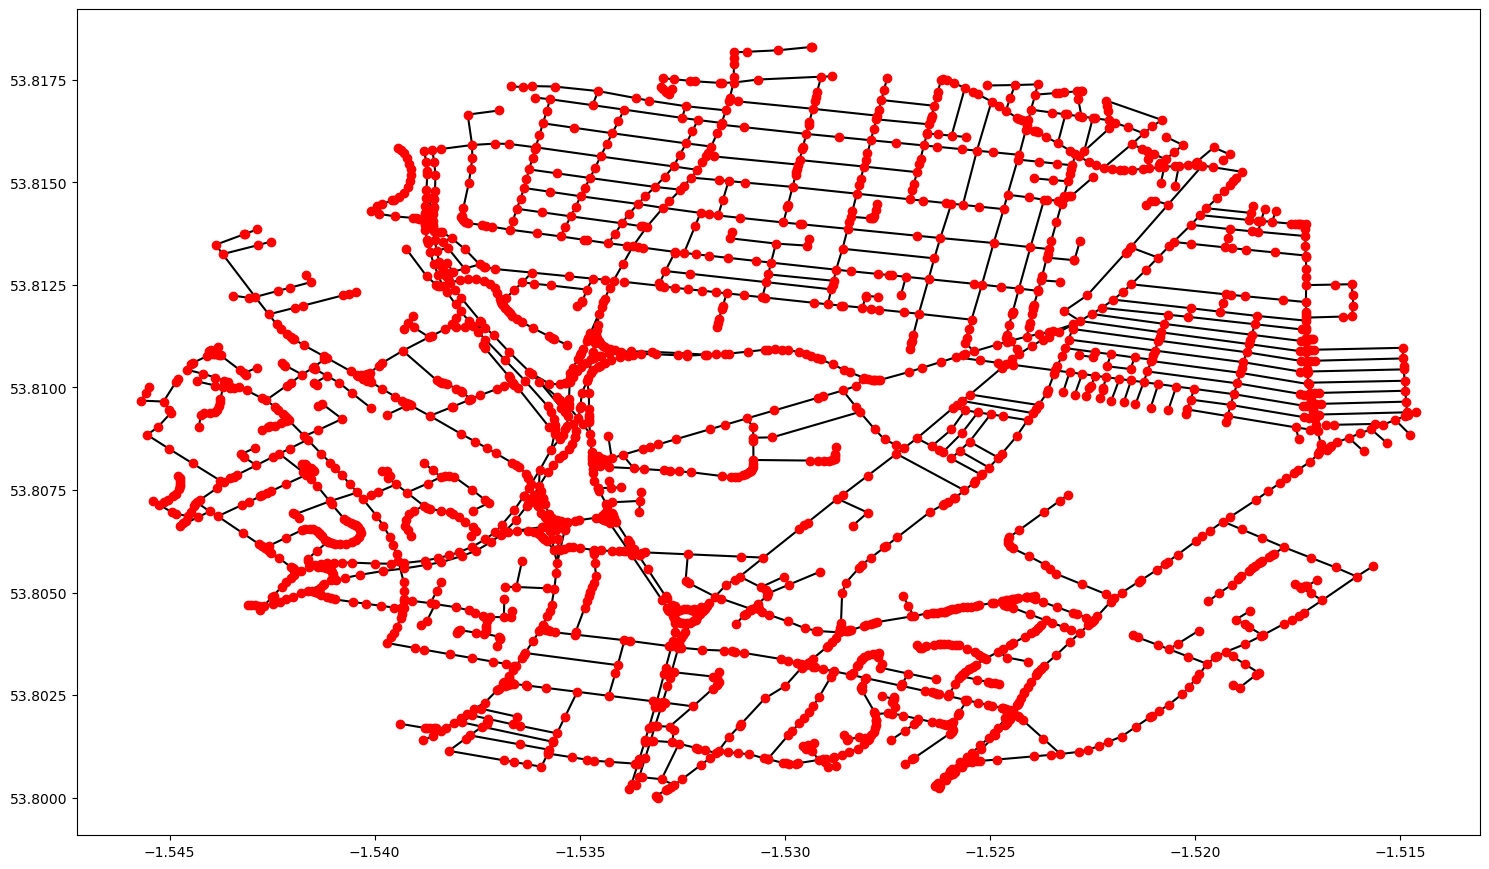

In [198]:
# From the GeoDataFrame, we can construct a network in Spaghetti from which to do point analysis
leeds_spagh_graph = spaghetti.Network(in_data=roads_geodataframe)

# Check what this new network looks like by getting DataFrames for the edges and plotting them
nodes_df, edges_df = spaghetti.element_as_gdf(
    leeds_spagh_graph, vertices=True, arcs=True)

base_network = edges_df.plot(color = "k", zorder=0, figsize=(15, 15))
nodes_df.plot(ax=base_network, color="r", zorder=2)

In [199]:
# We will now snap the leeds located accidents we extracted earlier, i.e. position them at the closest point on the closest road
leeds_spagh_graph.snapobservations(leeds_accident, 'accidents')

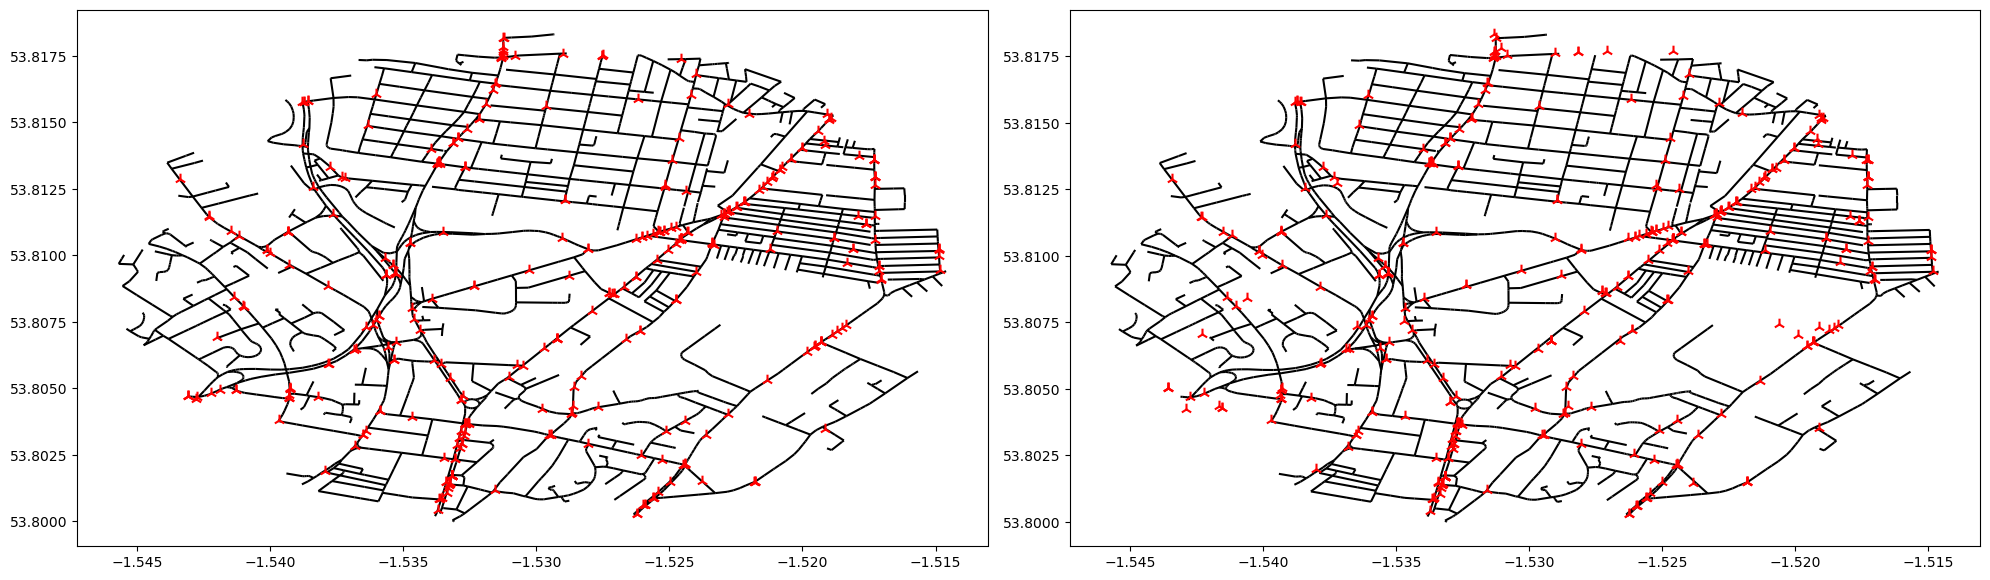

In [200]:
# Show the network
# Get a GeoDataFrame of the snapped crime locations to plot on the network image

observed_accidents=spaghetti.element_as_gdf(
    leeds_spagh_graph, pp_name='accidents', snapped=False)

snap_accident_points=spaghetti.element_as_gdf(
    leeds_spagh_graph, pp_name='accidents', snapped=True)

fig, axs = plt.subplots(1, 2, figsize=(20,40))

edges_df.plot(color="k", zorder=0, ax=axs[0])
edges_df.plot(color="k", zorder=0, ax=axs[1])

snap_accident_points.plot(color="r", marker="2", markersize=70, zorder=1, ax=axs[0])
observed_accidents.plot(color="r", marker="2", markersize=70, zorder=1, ax=axs[1])

plt.savefig('accidents-observations')
plt.show()

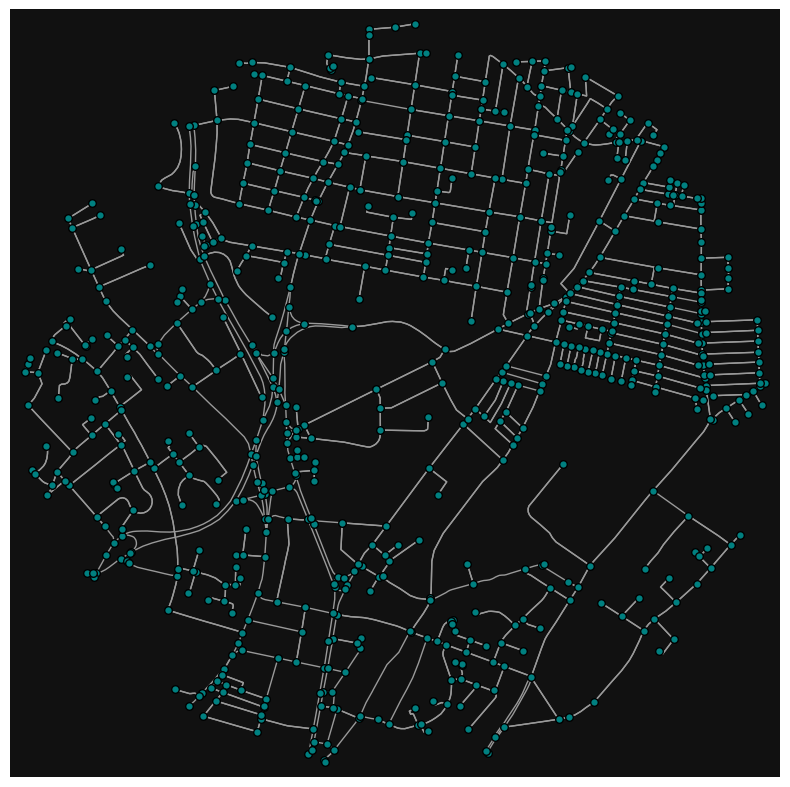

In [201]:
fig = osmnx.plot_graph(leeds_graph, node_color='teal', node_size=30,
node_zorder=2, node_edgecolor='k')

In [202]:
kres = leeds_spagh_graph.GlobalAutoK(leeds_spagh_graph.pointpatterns["accidents"],nsteps=100, permutations=100)

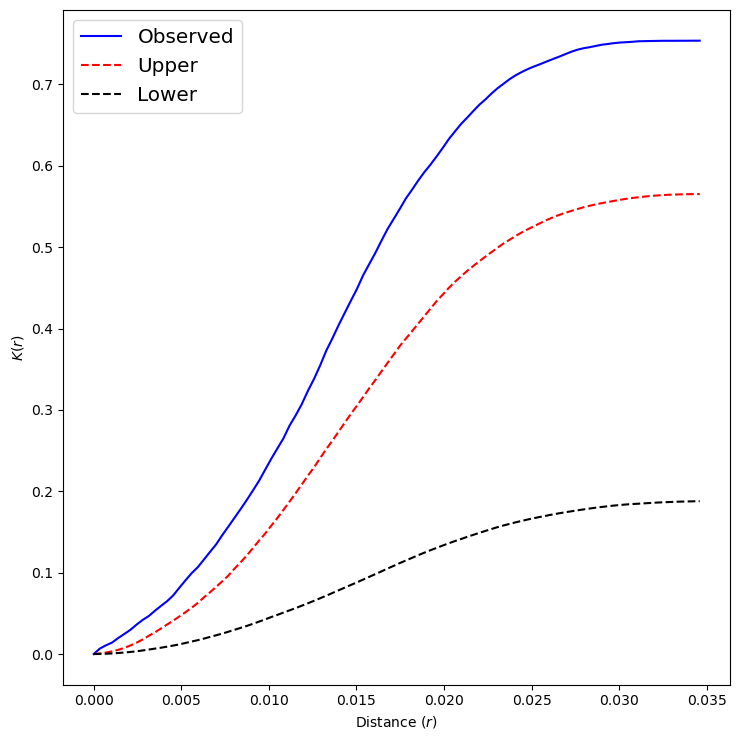

In [203]:
fig, ax = plt.subplots()

ax.plot(kres.xaxis, kres.observed, "b-", label="Observed")
ax.plot(kres.xaxis, kres.upperenvelope, "r--", label="Upper")
ax.plot(kres.xaxis, kres.lowerenvelope, "k--", label="Lower")

ax.legend(loc="best", fontsize="x-large")
ax.set_xlabel("Distance $(r)$")
ax.set_ylabel("$K(r)$")

plt.show()

In [359]:
# Get snapped point pattern 
pointpat = leeds_spagh_graph.pointpatterns['accidents']
# Get count of points per network edge: a dictionary from each edge to the crime count on that edge
counts = leeds_spagh_graph.count_per_link(pointpat.obs_to_arc, graph=False)
weights = leeds_spagh_graph.w_network

edges = weights.neighbors.keys()
# Construct an array of the counts values per edge in the same order as
# the weights matrix, with 0.0 where no counts recorded
values = [counts[edge] if edge in counts.keys () else 0. \
    for _, edge in enumerate(edges)]

In [361]:
moran = esda.moran.Moran(values, weights)
print("Moran I = ", moran.I) 
print("Moran P-Si = ", moran.p_sim)
print("Moran EI = ", moran.EI)
print("Moran EI-Sim ", moran.EI_sim)


Moran I =  0.14857507925599178
Moran P-Si =  0.001
Moran EI =  -0.00039277297721916735
Moran EI-Sim  -0.0007415713933646236


Text(0.5, 0, "Moran's I")

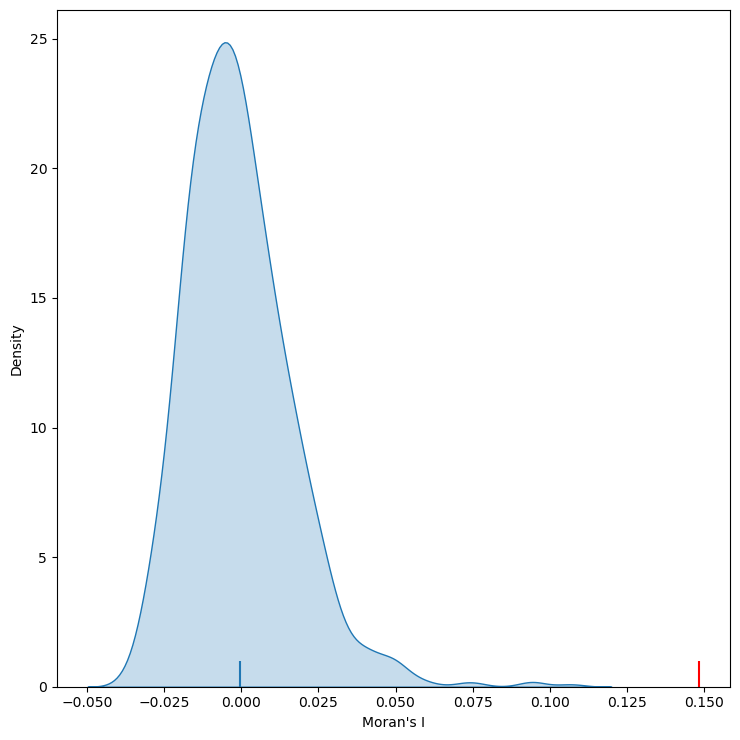

In [363]:
sns.kdeplot(moran.sim, shade=True)
plt.vlines(moran.I, 0, 1, color='r')
plt.vlines(moran.EI, 0,1)
plt.xlabel("Moran's I")

In [365]:
print("Moran Z-norm = ", moran.z_norm)
print("Moran Z-sim = ", moran.z_sim)

Moran Z-norm =  8.332217752188214
Moran Z-sim =  8.583822764706227


In [366]:
x_val = snap_accident_points.geometry.x
y_val = snap_accident_points.geometry.y

accident_street_pos = osmnx.nearest_edges(leeds_graph, x_val, y_val, interpolate=None, return_dist=False)

In [367]:
#compute fractions of street length that are closest to each accident point.
start_node_coords = np.array([(leeds_graph.nodes()[edge[0]]['y'], leeds_graph.nodes()[edge[0]]['x']) for edge in accident_street_pos])
end_node_coords = np.array([(leeds_graph.nodes()[edge[1]]['y'], leeds_graph.nodes()[edge[1]]['x']) for edge in accident_street_pos])
accident_pos = np.array([(Y[i], X[i]) for i in range(len(accident_street_pos))])

street_lengths = np.array([haversine(end_node_coords[i], start_node_coords[i], unit='km') for i in range(len(accident_street_pos))])
accident_dists_start = np.array([haversine(accident_pos[i], start_node_coords[i], unit='km') for i in range(len(accident_street_pos))])
accident_dists_end = np.array([haversine(accident_pos[i], end_node_coords[i], unit='km') for i in range(len(accident_street_pos))])

fractions = np.where(accident_dists_start >= accident_dists_end, accident_dists_end / street_lengths, accident_dists_start / street_lengths)


<Axes: >

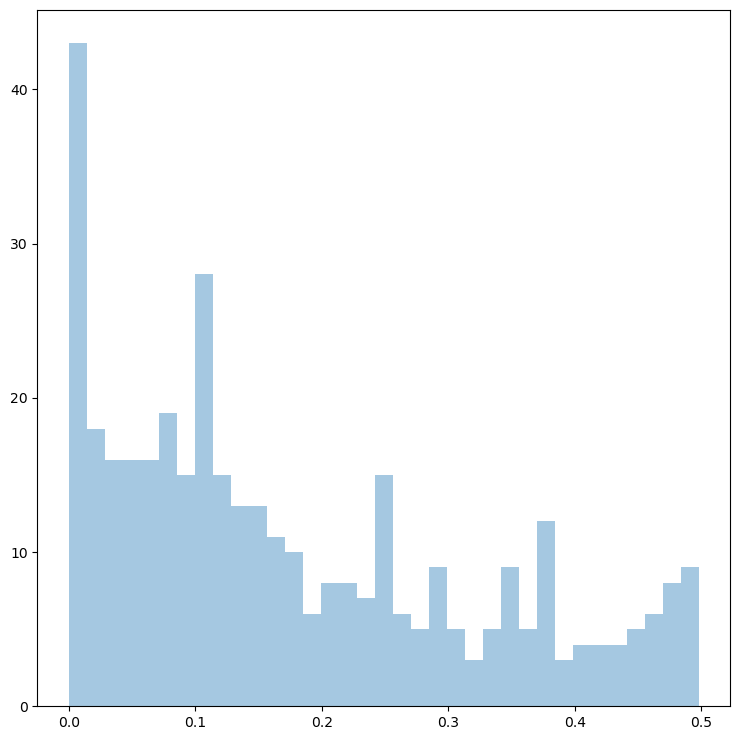

In [368]:
sns.distplot(fractions, bins=35, kde=False)

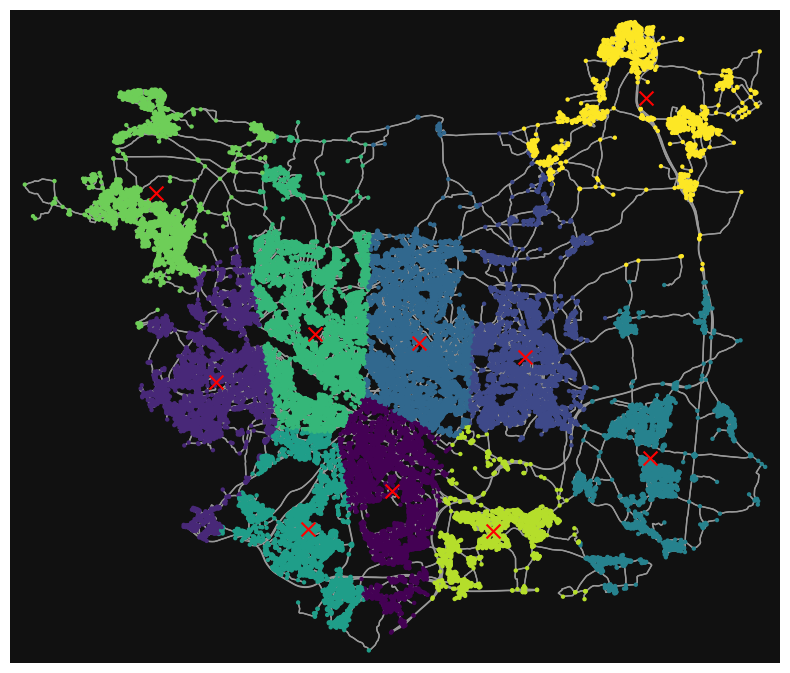

In [259]:
PLACE_OF_INTEREST = "Leeds, UK"
leeds_city_graph = osmnx.graph_from_place(PLACE_OF_INTEREST,network_type = 'drive')

# leeds_city_graph = leeds_graph

from sklearn.cluster import KMeans

NUMBER_OF_SEEDS = 10

all_nodes = list(leeds_city_graph.nodes(data=True))

# Apply k-means++ algorithm with k = NUMBER_OF_SEEDS to the nodes in the graph using the latitude and longitude as the features
kmeans = KMeans(init = 'k-means++', n_clusters=NUMBER_OF_SEEDS, n_init = "auto", random_state=42).fit([[node[1]['x'], node[1]['y']] for node in all_nodes])

# Get the cluster labels for each node
cluster_labels = kmeans.labels_

# Get the cluster centroids
cluster_centroids = kmeans.cluster_centers_

# Plot the graph with the nodes coloured by cluster label, and the cluster centroids as red crosses
fig, ax = osmnx.plot_graph(leeds_city_graph, node_color=cluster_labels, node_size=10, node_zorder=2, show=False, close=False)
ax.scatter(cluster_centroids[:,0], cluster_centroids[:,1], c='r', marker='x', s=100, zorder=3)
plt.show()

In [260]:
seeds = [osmnx.distance.nearest_nodes(leeds_city_graph, *centroid) for centroid in cluster_centroids]
print(cluster_centroids)
seeds

[[-1.54282862 53.76593795]
 [-1.65510924 53.80678731]
 [-1.45774306 53.81619964]
 [-1.52513308 53.82149739]
 [-1.37776633 53.77819558]
 [-1.59629679 53.75148662]
 [-1.59191329 53.82502075]
 [-1.69344286 53.8782089 ]
 [-1.47803598 53.75068581]
 [-1.38031242 53.91411188]]


[395305638,
 317598135,
 6481110432,
 248497502,
 1955838372,
 380917738,
 1690928998,
 1580869371,
 305698610,
 1560077]

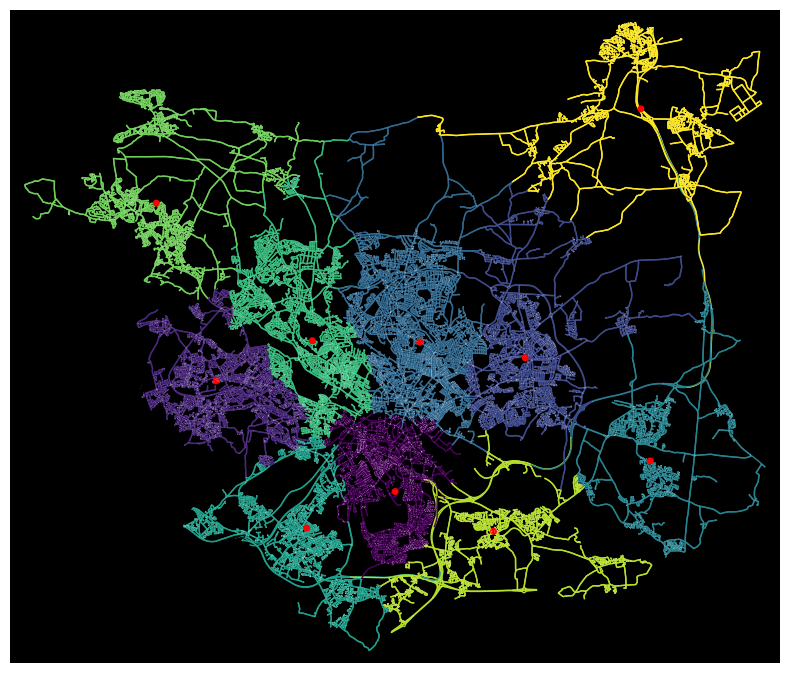

In [261]:
distances = {seed: nx.single_source_dijkstra_path_length(
    leeds_city_graph, seed, weight='length') for seed in seeds}

def nearest_from_list(node_distances):
    return sorted(node_distances, key=lambda node_length: node_length[1])[0] \
        if len(node_distances) > 0 else None

def nearest_seed(node):
    seed_distances = [(seed, distances[seed][node]) \
        for seed in seeds if node in distances[seed]]
    return nearest_from_list(seed_distances)

def nearest_for_edge(edge):
    nearest_to_ends_all = [nearest_seed(edge[0]), nearest_seed(edge[1])]
    nearest_to_ends = [distance for distance in nearest_to_ends_all if distance]
    return nearest_from_list(nearest_to_ends)

colours = osmnx.plot.get_colors(NUMBER_OF_SEEDS)

def colour_for_seed_distance(seed):
    return colours[seeds.index(seed[0])]

edge_nearest_seeds = [nearest_for_edge(edge) for edge in leeds_city_graph.edges]
# Note that edges not connected to a seed shown in black, so invisible on black background
edge_colours = [colour_for_seed_distance(seed) if seed else 'k' for seed in edge_nearest_seeds]
# edge_colours = np.array(edge_colours, dtype=object)
# For the road network nodes, we want the seeds to be coloured red and the non-seed nodes to be coloured white.
all_nodes = list(leeds_city_graph.nodes())
node_colours = ['r' if node in seeds else 'w' for node in all_nodes]
node_size = [25 if node in seeds else 0.1 for node in all_nodes]

# Plot the Voronoi diagram with 10 seed points and 10 cells (one for each seed point)
osmnx.plot.plot_graph(leeds_city_graph, edge_color = edge_colours, node_size = node_size, bgcolor = 'k', node_color = node_colours)
plt.show()

In [271]:
#dict to encode the colours
colour_set = list(set(edge_colours))
#sort so k is last
k_index = colour_set.index("k")
k_val = colour_set.pop(k_index)
colour_set.append(k_val)
colour_dict = {colour: i for i, colour in enumerate(colour_set)}
for i, (u,v,k) in enumerate(leeds_city_graph.edges):
    leeds_city_graph.edges[u,v,k]['color_code'] = colour_dict[edge_colours[i]]
# edge_colours

In [272]:
sub_graphs = []
for i in range(NUMBER_OF_SEEDS+1):
    sub_graph_edges = []
    for u,v,k in leeds_city_graph.edges:
        if leeds_city_graph.edges[u,v,k]['color_code'] == i:
            sub_graph_edges.append((u,v,k))
    subgraph = leeds_city_graph.edge_subgraph(sub_graph_edges)
    sub_graphs.append(subgraph)

seed_graphs = sub_graphs


In [273]:
# def get_path(seed_graph, starting_node):
#     current_node = starting_node
#     path_lengths = []
#     traversal_path = []
#     previous_node = ""
#     max_key = None
#     while sum(path_lengths) < 21000:
#         try:
#             paths_lengths = nx.single_source_dijkstra_path_length(seed_graph, current_node, weight='length')
#             #sort dicitoonary by value
#             sorted_lengths = {k: v for k, v in sorted(paths_lengths.items(), key=lambda item: item[1], reverse=True)}
#             if previous_node == max_key:
#                 del sorted_lengths[previous_node]
#             max_node = list(sorted_lengths.values())[0]
#             max_key = [k for k,v in paths_lengths.items() if v == max_node][0]
#             path_lengths.append(max_node)
#             while sum(path_lengths) > 21000:
#                 path_lengths.pop()
#                 try:
#                     del sorted_lengths[max_key]
#                 except(KeyError):
#                     continue
#                 max_node = list(sorted_lengths.values())[0]
#                 max_key = [k for k,v in paths_lengths.items() if v == max_node][0]
#                 path_lengths.append(max_node)
#             paths = nx.dijkstra_path(seed_graph, current_node, max_key, weight='length')
#             traversal_path= traversal_path[:-1] + paths
#             previous_node = current_node
#             current_node = max_key
#         except(IndexError):
#             print("No Exact Path Found using this starting node, closest path found is: ", sum(path_lengths))
#             break
#     return traversal_path, sum(path_lengths)

In [274]:
def get_path(seed_graph, starting_node):
    current_node = starting_node
    path_lengths = []
    traversal_path = []
    previous_node = ""
    while sum(path_lengths) < 21000:
        try:
            paths_lengths = nx.single_source_dijkstra_path_length(seed_graph, current_node, weight='length')
            sorted_lengths = sorted(paths_lengths.items(), key=lambda item: item[1], reverse=True)
            sorted_nodes = [node for node, length in sorted_lengths if node != previous_node]
            max_node = sorted_nodes[0]
            path_lengths.append(paths_lengths[max_node])
            while sum(path_lengths) > 21000:
                path_lengths = path_lengths[:-1]
                max_node = sorted_nodes[1]
                sorted_nodes = sorted_nodes[1:]
                path_lengths.append(paths_lengths[max_node])
            paths = nx.dijkstra_path(seed_graph, current_node, max_node, weight='length')
            traversal_path = traversal_path[:-1] + paths
            previous_node = current_node
            current_node = max_node
        except (IndexError, KeyError):
            print("No exact path found using this starting node, closest path found is: ", sum(path_lengths))
            break
    return traversal_path, sum(path_lengths)


In [275]:
# Find paths using random starting nodes (works for paths 0, 3-9)
seed_graph_starting_nodes = []
no_paths_found = []
p_length = 0
counter = 0
for i in range(0, NUMBER_OF_SEEDS):
    print(i)
    while p_length < 20950:
        seed_node = random.choice(list(seed_graphs[i].nodes))
        t_path,p_length = get_path(seed_graphs[i], seed_node)
        start_node = t_path[0]
        counter += 1
        if counter > 100:
            no_paths_found.append(i)
            break
    counter = 0
    p_length = 0
    seed_graph_starting_nodes.append(start_node)
print(no_paths_found)
# # Brute force testing every node as a starting node (works for paths 1 and 2)
# path_length_pairs = []
# for seed_node in seed_graphs[2].nodes:
#     t_path,p_length = get_path(seed_graphs[2], seed_node)
#     start_node = t_path[0]
#     path_length_pairs.append((start_node, p_length))

0
No exact path found using this starting node, closest path found is:  20861.881
No exact path found using this starting node, closest path found is:  0
No exact path found using this starting node, closest path found is:  20994.417
1
No exact path found using this starting node, closest path found is:  10205.196
No exact path found using this starting node, closest path found is:  9647.372
No exact path found using this starting node, closest path found is:  14633.077
No exact path found using this starting node, closest path found is:  9998.915
No exact path found using this starting node, closest path found is:  12593.668999999996
No exact path found using this starting node, closest path found is:  12629.944
No exact path found using this starting node, closest path found is:  9021.822999999999
No exact path found using this starting node, closest path found is:  10336.245999999997
No exact path found using this starting node, closest path found is:  13729.301
No exact path found 

In [276]:
# #Checking paths to troubleshooting
# print(path_length_pairs)
# path_length_pairs.sort(key=lambda x: x[1], reverse=True)

#filter for values between 10000 and 11000
# filtered_pairs = [x for x in path_length_pairs if x[1] > 10490 and x[1] < 10510]
# filtered_pairs

# # City center srating nodes
# starting_node_list = seed_graph_starting_nodes
# Whole city starting nodes
starting_node_list = [3181253378, 364384983, 1985025822, 690265820, 6784998070, 317600313, 1715201705, 21428171, 27563136, 250074116]

In [277]:
marathon_paths = []
marathon_lengths = []
for i, starting_node in enumerate(starting_node_list):
    t_path,p_length = get_path(seed_graphs[i], starting_node)
    marathon_paths.append(t_path)
    marathon_lengths.append(p_length)

No exact path found using this starting node, closest path found is:  20420.914999999997
No exact path found using this starting node, closest path found is:  10499.439999999997
No exact path found using this starting node, closest path found is:  20553.784
No exact path found using this starting node, closest path found is:  20999.464
No exact path found using this starting node, closest path found is:  20973.500000000004
No exact path found using this starting node, closest path found is:  20977.270000000004
No exact path found using this starting node, closest path found is:  20997.48
No exact path found using this starting node, closest path found is:  20992.232
No exact path found using this starting node, closest path found is:  20988.361000000004
No exact path found using this starting node, closest path found is:  20999.372


In [278]:
#  Compute Alternate Path for Full Leed Graph Marathon Path 2
print(marathon_paths[2])
# Compute fraction from starting node of marathon path 2
check_lengths = nx.single_source_dijkstra_path_length(seed_graphs[2], 765227730, weight='length')
print(seed_graphs[2].edges(765227730))
# [(765227730, 765229124), (765227730, 21436381), (765227730, 765234932)]
check_lengths[21436381]
test_path_2 = marathon_paths[2][3:]
test_path_2.insert(0, 21436381)
# test_path.insert(0, 495969140)

#compute path length
def compute_path_length(test_path, test_graph):
    path_length = 0
    for i in range(len(test_path)-1):
        path_length += test_graph.edges[test_path[i], test_path[i+1],0]['length']
    return path_length


partial_path_length = compute_path_length(test_path_2[1:], seed_graphs[2])
single_path_length = compute_path_length(test_path_2[:2], seed_graphs[2])
required_path_length = 21000 - partial_path_length
print("Starting Node", test_path_2[0])
print("Starting Edge", test_path_2[:2])
edge_fraction = required_path_length/single_path_length
print("Fraction of starting Edge required", edge_fraction)
print("Distance from Starting Node where Start should be", single_path_length - single_path_length*edge_fraction)

marathon_paths[2] = test_path_2

osmnx.folium.plot_route_folium(leeds_city_graph, test_path_2, route_color='r', node_size = 0, route_linewidth=6)

[1985025822, 765227720, 765229124, 765227730, 765234932, 21436395, 373372258, 27456692, 21436397, 367293090, 1581058352, 798056773, 1652885241, 26261624, 907813435, 907813515, 248091811, 248091812, 907813493, 907813314, 389906705, 907813348, 907813331, 907813436, 26261629, 26261630, 27480801, 13807346, 798122888, 798155388, 907813562, 2049640597, 1984729084, 277967129, 2050307361, 277967121, 277967122, 1581182921, 1581182854, 1581182956, 1581182906, 1581183030, 1581183038, 1554569, 1554000, 1553845, 1553614, 319599]
[(765227730, 765229124), (765227730, 21436381), (765227730, 765234932)]
Starting Node 21436381
Starting Edge [21436381, 765227730]
Fraction of starting Edge required 0.43128139675447513
Distance from Starting Node where Start should be 792.2580000000044


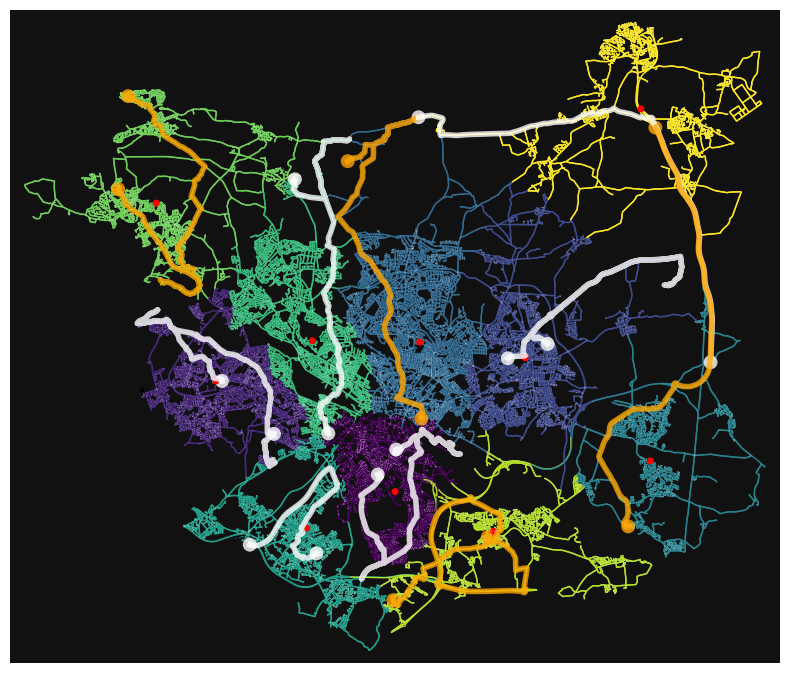

In [279]:
# Plot the Voronoi diagram with 10 seed points and 10 cells (one for each seed point)
fig, ax = osmnx.plot_graph(leeds_city_graph, node_color=node_colours, edge_color=edge_colours, node_size=node_size, node_zorder=2, show=False, close=False)
osmnx.plot.plot_graph_routes(leeds_city_graph, marathon_paths, route_colors=['orange','w','w','w','orange','w','orange','w','orange','w'], route_linewidth=3, node_size=0, route_alpha=0.8, bgcolor='k', ax=ax, show=False, close=False)
# osmnx.plot.plot_graph_route(leeds_city_graph, removed_path, route_color='r', route_linewidth=3, node_size=0, route_alpha=0.4, bgcolor='k', ax=ax)
plt.show()

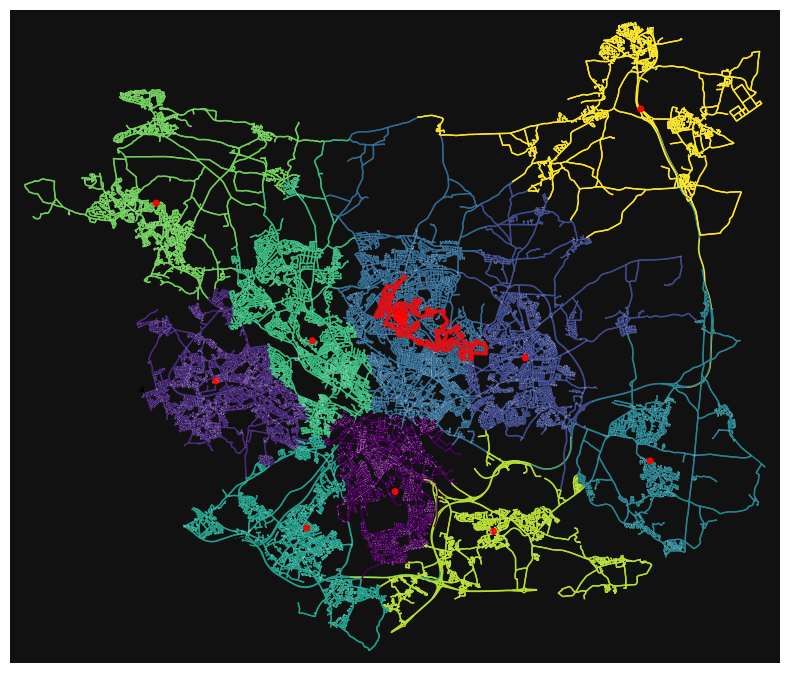

In [289]:
# Plot the Voronoi diagram with 10 seed points and 10 cells (one for each seed point)
fig, ax = osmnx.plot_graph(leeds_city_graph, node_color=node_colours, edge_color=edge_colours, node_size=node_size, node_zorder=2, show=False, close=False)
osmnx.plot.plot_graph_route(leeds_city_graph, cycle, route_color="r", route_linewidth=3, node_size=0, route_alpha=0.8, bgcolor='k', ax=ax, show=False, close=False)
# osmnx.plot.plot_graph_route(leeds_city_graph, removed_path, route_color='r', route_linewidth=3, node_size=0, route_alpha=0.4, bgcolor='k', ax=ax)
plt.show()